In [6]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import copy
from torch import nn
from torch.utils import data
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from omegaconf import OmegaConf, DictConfig
from ml_utilities.torch_models import get_model_class
from ml_utilities.torch_utils import gradients_to_vector
from erank.data.datasetgenerator import DatasetGenerator
from erank.gradients import GradientCalculator
from erank.analyses import create_model_erank_df
from erank.plot import plot_models_erank
import matplotlib.pyplot as plt
gpu_id = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 12.1.1 Local Gradient Experiment
We compute local gradients of a model pretrained for `pretrain_steps` on rotation 0° with mnist rotated with `rotation_angle`.

We use Lenet and rotated MNIST in this experiment.

In [7]:
pretrain_steps = 50
rotation_angle = 0

## Setup

In [8]:
cfg = f"""
dataset_generator_kwargs:
  dataset: rotatedvision
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data #/home/max/phd/data 
    dataset: mnist
    rotation_angle: {rotation_angle}
  dataset_split:
    train_val_split: 0.8

run_path: /system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.5.0-lenet--221015_122552
model_idx: {pretrain_steps}
default_loss: crossentropy
device: {gpu_id}
"""
cfg = OmegaConf.create(cfg)

In [9]:
gradient_calculator = GradientCalculator(**cfg)

## Gradient Erank Plots

In [10]:
# create gradients bs dict
batch_sizes = [128, 32, 8]
grad_bs_dict = {}
for bs in batch_sizes:
    grad_bs_dict[bs] = torch.stack(gradient_calculator.compute_gradients(batch_size=bs))

100%|██████████| 6000/6000 [00:25<00:00, 233.33it/s]


In [11]:
erank_df = create_model_erank_df(grad_bs_dict, device=gpu_id)

Calculate eranks: 100%|██████████| 39/39 [00:09<00:00,  4.17it/s]


In [12]:
erank_df

,128,32,8,Gaussian random
Number of Vectors,,,,
1,1.000000,1.000000,1.000000,1.000000
11,8.873396,9.545002,9.100777,10.999938
21,15.001503,16.542755,15.442375,20.999805
31,20.503992,23.044176,20.959995,30.999548
41,25.858948,28.980062,26.926201,40.999218
51,31.170040,34.972687,32.903763,50.998711
61,35.948925,40.647049,37.468319,60.998215
71,41.133469,46.241131,42.606880,70.997536
81,46.125484,52.000755,47.737984,80.996841


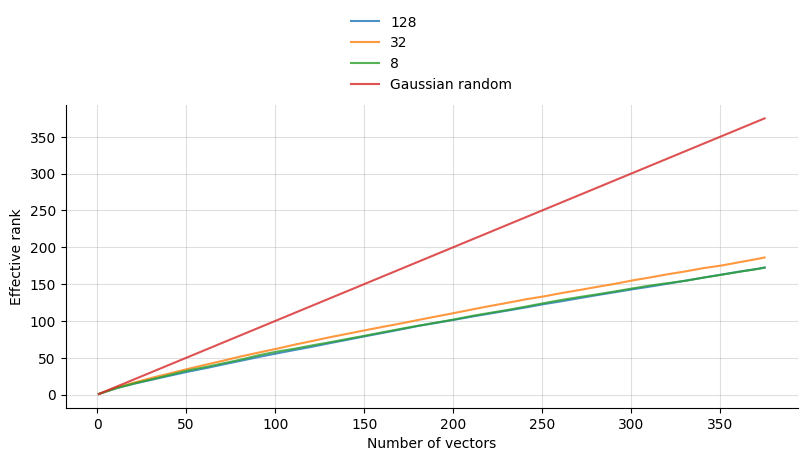

In [13]:
# erank of gradients for different batch sizes
f = plot_models_erank(erank_df=erank_df)

In [14]:
# smaller batch size has higher erank -> Explanation: more gradient noise

Calculate eranks: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


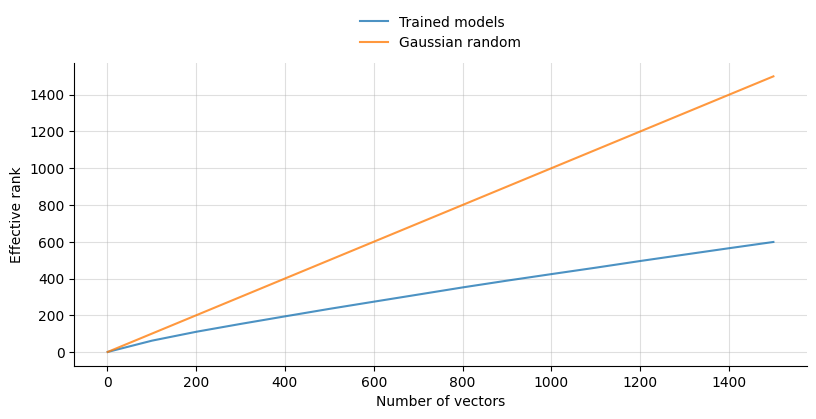

In [15]:
# batch size 
bs = 32
erank_df = create_model_erank_df(grad_bs_dict[bs], device=gpu_id, model_steps=100)
f = plot_models_erank(erank_df)

In [16]:
erank_df

,Trained models,Gaussian random
Number of Vectors,,
1,1.000000,1.000000
101,62.473816,100.995026
201,110.882004,200.981155
301,153.590485,300.957245
401,194.731049,400.924225
501,235.417145,500.881775
601,274.431244,600.830017
701,313.149506,700.769104
801,352.035950,800.697998


In [17]:
# batch size 
# bs = 8
# erank_df = create_model_erank_df(grad_bs_dict[bs], device=gpu_id, model_steps=100)
# f = plot_models_erank(erank_df)